In [1]:
###### HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
from pandas_ods_reader import read_ods #read ods tables

import matplotlib 
import matplotlib.pyplot as plt # plot library
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
from matplotlib import cm
from mycolorpy import colorlist as mcp # color levels from a color map

import subprocess # these 2 lines below load OS functionality
import sys
import json
import warnings
 
from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.special as spec
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions
import scipy.optimize as optimize # optimazation library (not used)
from scipy import signal # noise filtering functions
from scipy import stats # statistics, for binning and fields calculation
from scipy.fft import fft, ifft, fftfreq

from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions


import ipywidgets as widgets # import 

import time # timing functions (for computation time)
from pytictoc import TicToc

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial'], 'size': 14})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

In [2]:
%matplotlib ipympl

In [3]:
# Calculate time correlation by using arrays (faster)
# 'array' is the array over which autocorrelation is computed. 'demom' is a normalization factor. 
# 'it' is the no. of time values on which autocorrelation is computerd
# cross correlations (auto correlations if array1=array2)
def time_shift_np_av(array1, array2 ,denom, ilag):
    if ilag>0:
        return np.mean(array1[:-ilag] * array2[ilag:])/denom
    else:
        return np.mean(array1 * array2)/denom
# displacement correlations (mean squared displacement if array1=array2)
def time_diff_shift_np_av(array1, array2, array3, array4, ilag):
    if ilag>0:
        return np.mean( (array1[:-ilag]-array2[ilag:]) * (array3[:-ilag]-array4[ilag:]) )
    else:
        return np.mean( (array1-array2) * (array3-array4) )
    
# convolution
def neg_time_shift_np_av(array1, array2 ,denom, ilag):
    return np.mean(array1[:-ilag] * array2[ilag:])/denom

In [4]:
# READ TRACK FILES
# determine the number of tracks in the data directory
nfiles =  !ls /home/fvega/Datos/brownian/*xz | wc -l
nfiles = int(nfiles[0])
# all tracks are compressed in 'xz' format
files = !ls /home/fvega/Datos/brownian/*xz 

# create one data table (pandas format) per track file
datos = [pd.DataFrame() for i in range(nfiles)]

rc = 80
rc2 = rc*rc

# create 1 time, space, and velocity array for each track
t = [[] for i in range(nfiles)] 

X = [[] for i in range(nfiles)] 
Y = [[] for i in range(nfiles)]
Vx = [[] for i in range(nfiles)] 
Vy = [[] for i in range(nfiles)]
# additionally, create one temperature array for each track
Tt = np.zeros(nfiles)


for i in range(nfiles):
    datos[i] = pd.read_pickle(files[i], compression='xz')
    t[i] = datos[i].t.values
    # tracks (trajectories) are to be smoothed out, since frame rate is far above needed
    X[i] = signal.savgol_filter(datos[i].x.values, 7, 3)
    Y[i] = signal.savgol_filter(datos[i].y.values, 7, 3)
    # velocities are built within the linear approximation from the smoothed tracks
    Vx[i] = np.diff(X[i])/np.diff(t[i])
    Vy[i] = np.diff(Y[i])/np.diff(t[i])
    
    print('nframes: ', len(datos[i]))

# PHYSICAL MAGNITUDES TO BE ANALYZED
Av = [[] for i in range(nfiles)]
MSD = [[] for i in range(nfiles)]
XSD = [[] for i in range(nfiles)]
D_t = [[] for i in range(nfiles)]
Dodd_t = [[] for i in range(nfiles)]
# if other magnitudes are to be analyzed, add array definitions here below


for i in range(nfiles): 
    Tt[i] = np.mean( (Vx[i]-np.mean(Vx[i]))**2 )/rc2 + np.mean( (Vy[i]- np.mean(Vy[i]))**2 )/rc2
    Av[i] = np.zeros(Vx[i].size)
    A0 = time_shift_np_av(Vx[i],Vx[i],1,0) + time_shift_np_av(Vy[i], Vy[i], 1, 0)
    MSD[i] = np.zeros(Vx[i].size)
    XSD[i] = np.zeros(Vx[i].size)
    for it in range(1, Vx[i].size):
        Av[i][it] = time_shift_np_av(Vx[i], Vx[i], A0, it) + time_shift_np_av(Vy[i], Vy[i], A0, it)
        MSD[i][it] = time_diff_shift_np_av(X[i], X[i], X[i], X[i], it) + time_diff_shift_np_av(Y[i], Y[i], Y[i], Y[i], it)
        XSD[i][it] = time_diff_shift_np_av(X[i], X[i], Y[i], Y[i], it)
    Av[i][0] = 1. 

nframes:  38419
nframes:  38419
nframes:  38419
nframes:  38419
nframes:  37000


In [34]:
# data frame structure (non-smoothed tracks)
# Time unit is seconds
# Position is in pixel units

datos[0].head()

,x,y,t
0,448.3525,304.5842,0.000000
1,448.3929,304.5802,0.001333
2,448.3916,304.5321,0.002667
3,448.3341,304.5202,0.004000
4,448.3388,304.5475,0.005333


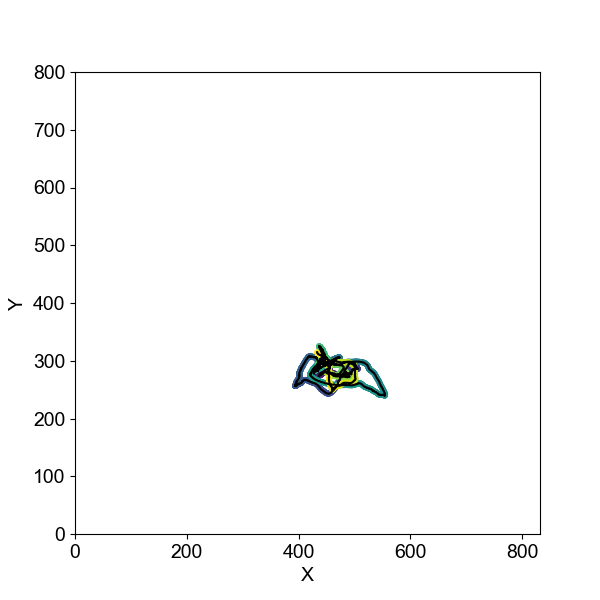

In [35]:
# TRAJECTORY REPRESENTATION 
plt.figure(0,figsize=(6,6))
plt.xlim(0,832)
plt.ylim(0,800)
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X[0],Y[0], c='k')
plt.scatter(datos[0].x.values[::10], datos[0].y.values[::10], s=10, c=datos[0].t.values[::10], cmap='viridis')


In [36]:
plt.close(0) # before plotting again the same figure, close its variable

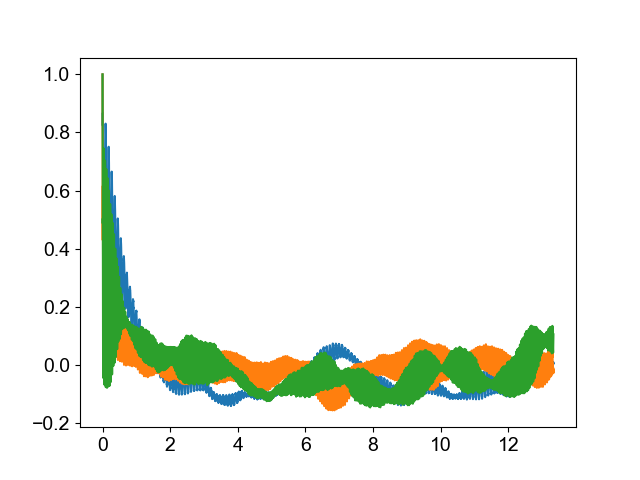

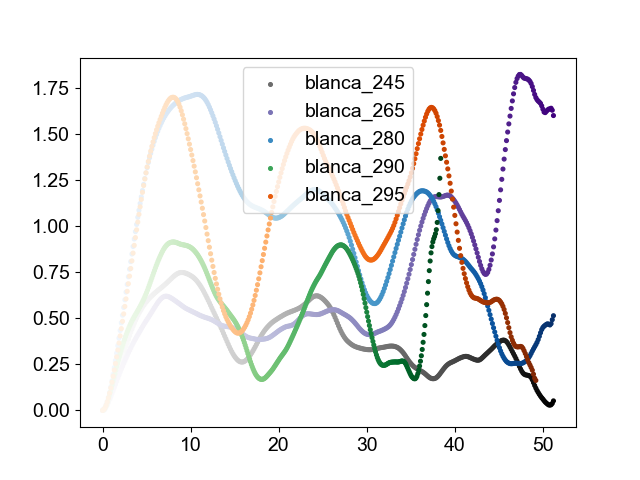

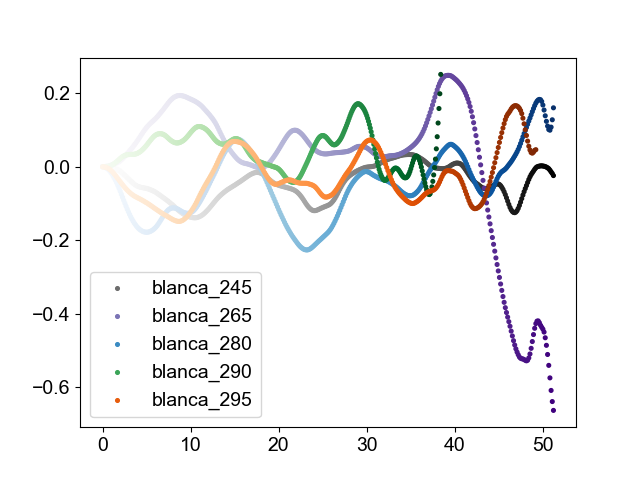

In [98]:
plt.figure(1)
t_end = 10000
plt.plot(t[0][:t_end], Av[0][:t_end])
plt.plot(t[2][:t_end], Av[1][:t_end])
plt.plot(t[4][:t_end], Av[4][:t_end])


colors = [ [] for i in range(nfiles)]
col_maps = [ "Greys", "Purples", "Blues", "Greens", "Oranges", "Reds"]
labels = [ files[i][-17:-7] for i in range(nfiles)] # data sets labels

step = 100 # interval between plotted points (so that not too many points appear in the graph)
rc = 80 # scale for positions (80 pixels ~1 cm)

plt.figure(2)
for i in range(nfiles):
    colors[i] = mcp.gen_color(cmap=col_maps[i],n=MSD[i].size) 
    plt.scatter(t[i][:-1:step], MSD[i][::step]/(rc*rc),c=colors[i][::step], s= 7, label = labels[i])
leg=plt.legend()
LH = leg.legend_handles
for i in range(nfiles):
    LH[i].set_color(colors[i][25000])  # asign lat point color for legend


plt.figure(3)
for i in range(nfiles):
    colors[i] = mcp.gen_color(cmap=col_maps[i],n=XSD[i].size)
    plt.scatter(t[i][:-1:step], XSD[i][::step]/(rc*rc),c=colors[i][::step], s= 7, label = labels[i])
leg=plt.legend()
LH = leg.legend_handles
for i in range(nfiles):
    LH[i].set_color(colors[i][25000])  # asign lat point color for legend


In [97]:
plt.close(1)
plt.close(2)
plt.close(3)

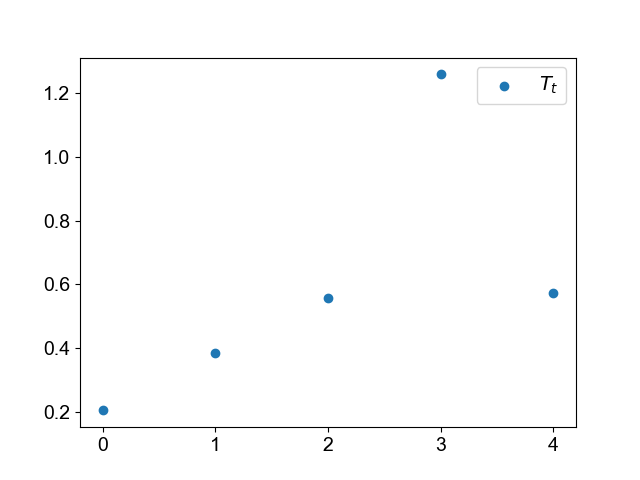

In [70]:
plt.figure(4)
plt.scatter([i for i in range(nfiles)],Tt, label=r'$T_t$')
plt.legend()

In [69]:
plt.close(4)

In [6]:
Dodd_xy = 0.
Dodd_yx = 0.
vx = np.diff(datos.x.values)/np.diff(datos.t.values)
vy = np.diff(datos.y.values)/np.diff(datos.t.values)
for ilag in range(1,int(nframes-1)):
    Dodd_yx = Dodd_yx - time_shift_np_av(vx, vy, 750, ilag)     
    Dodd_xy = Dodd_xy + time_shift_np_av(vy, vx, 750, ilag)
    if ilag%100==0:
        printp('Dodd_xy: ' + str(Dodd_xy) + '\tDodd_yx: ' + str(Dodd_yx) )
Dodd = -(Dodd_xy + Dodd_yx)/2
print('\n')
print('Dodd = ', Dodd, '\n\n')

D_y = 0.
D_x = 0.
for ilag in range(1,int(nframes/2)):
    D_x = D_x + time_shift_np_av(vx , vx, 750, ilag) 
    D_y = D_y + time_shift_np_av(vy , vy, 750, ilag) 
    if ilag%100 ==0:
        printp('D_x: ' + str(D_x) + '\tD_y: ' + str(D_y))
D = (D_x + D_y)/2
print('\n')
print('D = ', D)


Dodd_xy: 877.4741698465243	Dodd_yx: 684.3136742543377526

Dodd =  -781.275265452279 


D_x: 78.87955674685355	D_y: 71.533498960949842639

D =  74.39878044882262


In [99]:
datos = pd.read_pickle('blanca_265.pkl.xz', compression='xz')
nframes = len(datos)
print('nframes = ', nframes, '\n')
datos.head()

nframes =  38419 



,x,y,t
0,356.8108,324.4761,0.000000
1,356.7963,324.6939,0.001333
2,356.6393,324.4116,0.002667
3,356.7278,324.7062,0.004000
4,356.8720,324.5697,0.005333


In [101]:
Dodd_xy = 0.
Dodd_yx = 0.
vx = np.diff(datos.x.values)/np.diff(datos.t.values)
vy = np.diff(datos.y.values)/np.diff(datos.t.values)
for ilag in range(1,int(nframes-1)):
    Dodd_yx = Dodd_yx - time_shift_np_av(vx, vy, 750, ilag)     
    Dodd_xy = Dodd_xy + time_shift_np_av(vy, vx, 750, ilag)
    if ilag%100==0:
        printp('Dodd_xy: ' + str(Dodd_xy) + '\tDodd_yx: ' + str(Dodd_yx) )
Dodd = -(Dodd_xy + Dodd_yx)/2
print('\n')
print('Dodd = ', Dodd, '\n\n')

D_y = 0.
D_x = 0.
for ilag in range(1,int(nframes/2)):
    D_x = D_x + time_shift_np_av(vx , vx, 750, ilag) 
    D_y = D_y + time_shift_np_av(vy , vy, 750, ilag) 
    if ilag%100 ==0:
        printp('D_x: ' + str(D_x) + '\tD_y: ' + str(D_y))
D = (D_x + D_y)/2
print('\n')
print('D = ', D)

Dodd_xy: -203.3842999688498	Dodd_yx: 862.6971241837231331

Dodd =  -312.91701676522905 


D_x: 78.99993271420287	D_y: -49.187752422523935356

D =  14.551860312594627


In [93]:
datos = pd.read_pickle('blanca_280.pkl.xz', compression='xz')
nframes = len(datos)
print('nframes = ', nframes, '\n')
datos.head()

nframes =  38419 



,x,y,t
0,403.5786,327.5759,0.000000
1,403.2739,327.7152,0.001333
2,403.5368,327.5658,0.002667
3,403.4625,327.8450,0.004000
4,403.3911,327.5489,0.005333


In [98]:
Dodd_xy = 0.
Dodd_yx = 0.
vx = np.diff(datos.x.values)/np.diff(datos.t.values)
vy = np.diff(datos.y.values)/np.diff(datos.t.values)
for ilag in range(1,int(nframes-1)):
    Dodd_yx = Dodd_yx - time_shift_np_av(vx, vy, 750, ilag)     
    Dodd_xy = Dodd_xy + time_shift_np_av(vy, vx, 750, ilag)
    if ilag%100==0:
        printp('Dodd_xy: ' + str(Dodd_xy) + '\tDodd_yx: ' + str(Dodd_yx) )
Dodd = -(Dodd_xy + Dodd_yx)/2
print('\n')
print('Dodd = ', Dodd, '\n\n')

D_y = 0.
D_x = 0.
for ilag in range(1,int(nframes-1)):
    D_x = D_x + time_shift_np_av(vx , vx, 750, ilag) 
    D_y = D_y + time_shift_np_av(vy , vy, 750, ilag) 
    if ilag%100 ==0:
        printp('D_x: ' + str(D_x) + '\tD_y: ' + str(D_y))
D = (D_x + D_y)/2
print('\n')
print('D = ', D)

Dodd_xy: 385.6079690718922	Dodd_yx: 535.1225368480464577

Dodd =  -474.1047153017971 


D_x: 54.31646928192411	D_y: 147.74246479692465435

D =  107.70052093429038


In [7]:
datos = pd.read_pickle('/home/fvega/Datos/brownian/blanca_290.pkl.xz', compression='xz')
nframes = len(datos)
print('nframes = ', nframes, '\n')
datos.head()

nframes =  38419 



,x,y,t
0,425.1728,332.6562,0.000
1,424.6716,332.5420,0.001
2,425.2595,332.6136,0.002
3,425.0071,332.6935,0.003
4,424.9840,332.6677,0.004


In [61]:
X = signal.savgol_filter(datos.x.values, 7, 3)
Y = signal.savgol_filter(datos.y.values, 7, 3)
t = datos.t.values

In [9]:
Dodd_xy = 0.
Dodd_yx = 0.
vx = np.diff(datos.x.values)/np.diff(datos.t.values)
vy = np.diff(datos.y.values)/np.diff(datos.t.values)
for ilag in range(1,int(nframes/2)):
    Dodd_yx = Dodd_yx - time_shift_np_av(vx, vy, 750, ilag)     
    Dodd_xy = Dodd_xy + time_shift_np_av(vy, vx, 750, ilag)
    if ilag%100==0:
        printp('Dodd_xy: ' + str(Dodd_xy) + '\tDodd_yx: ' + str(Dodd_yx) )
Dodd = -(Dodd_xy + Dodd_yx)/2
print('\n')
print('Dodd = ', Dodd, '\n\n')

D_y = 0.
D_x = 0.
for ilag in range(1,int(nframes/2)):
    D_x = D_x + time_shift_np_av(vx , vx, 750, ilag) 
    D_y = D_y + time_shift_np_av(vy , vy, 750, ilag) 
    if ilag%100 ==0:
        printp('D_x: ' + str(D_x) + '\tD_y: ' + str(D_y))
D = (D_x + D_y)/2
print('\n')
print('D = ', D)

Dodd_xy: -156.8473736034209	Dodd_yx: -134.546123197870685

Dodd =  145.14086141711226 


D_x: 62.62248729850968	D_y: 326.19450927938664735

D =  196.11816002739943


In [70]:
Dodd_xy = 0.
Dodd_yx = 0.
vx = np.diff(X)/np.diff(t)
vy = np.diff(Y)/np.diff(t)
for ilag in range(1,int(nframes-1)):
    Dodd_yx = Dodd_yx - time_shift_np_av(vx, vy, 750, ilag)     
    Dodd_xy = Dodd_xy + time_shift_np_av(vy, vx, 750, ilag)
    if ilag%100==0:
        printp('Dodd_xy: ' + str(Dodd_xy) + '\tDodd_yx: ' + str(Dodd_yx) )
Dodd = -(Dodd_xy + Dodd_yx)/2
print('\n')
print('Dodd = ', Dodd, '\n\n')

D_y = 0.
D_x = 0.
for ilag in range(1,int(nframes-1)):
    D_x = D_x + time_shift_np_av(vx , vx, 750, ilag) 
    D_y = D_y + time_shift_np_av(vy , vy, 750, ilag) 
    if ilag%100 ==0:
        printp('D_x: ' + str(D_x) + '\tD_y: ' + str(D_y))
D = (D_x + D_y)/2
print('\n')
print('D = ', D)

Dodd_xy: 1603.5927128919698	Dodd_yx: -396.336029850591444

Dodd =  -603.0935374576411 


D_x: 123.68686571350858	D_y: 1938.058341815234487

D =  1047.743316789173


In [71]:
msd = np.zeros(nframes-1)
xsd = np.zeros(nframes-1)
x = X
y = Y

for ilag in range(1,int(nframes-1)):
    msd[ilag] = time_diff_shift_np_av(x, x, ilag) + time_diff_shift_np_av(y, y, ilag)
    xsd[ilag] = time_diff_shift_np_av(x, y, ilag)
    if ilag%100==0:
        printp('msd(' + str(ilag) +'): ' + str(msd[ilag]) + '\txsd(' + str(ilag) +'): ' + str(xsd[ilag]))


msd(38400): 8750.204786254857	xsd(38400): 33949.4704615985544

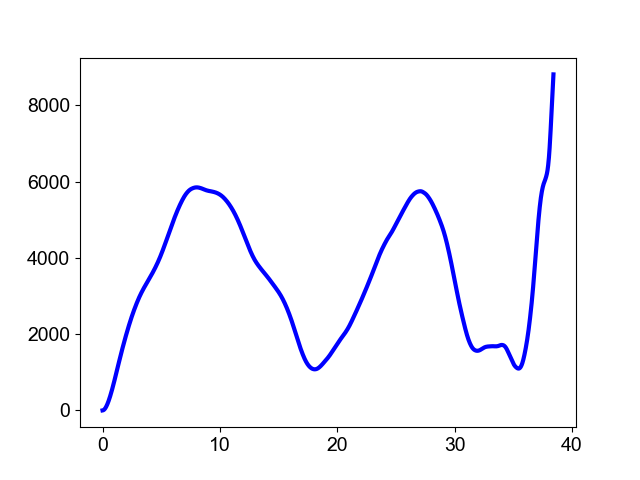

In [74]:
plt.figure(1)
plt.plot(datos.t.values[:-1], msd, color='blue', lw=3)

In [73]:
plt.close(1)

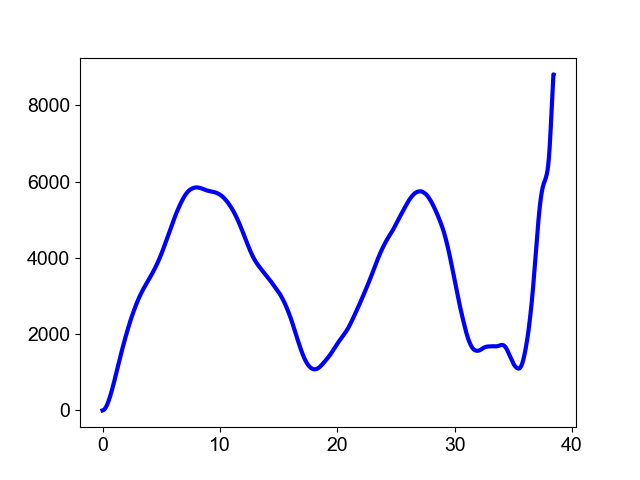

In [19]:
plt.figure(1)
plt.plot(datos.t.values[:-1], msd, color='blue', lw=3)

In [18]:
plt.close(1)

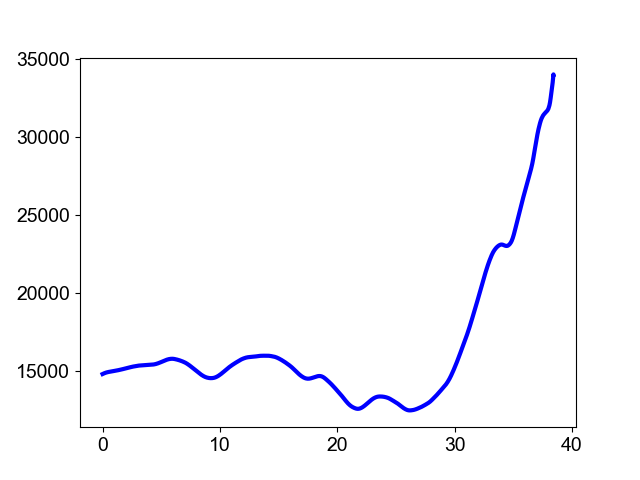

In [20]:
plt.figure(2)
plt.plot(datos.t.values[:-3], xsd[2:], color='blue', lw=3)

In [23]:
plt.close(3)

In [16]:
datos[0].head(

,x,y,t
0,448.3525,304.5842,0.000000
1,448.3929,304.5802,0.001333
2,448.3916,304.5321,0.002667
3,448.3341,304.5202,0.004000
4,448.3388,304.5475,0.005333


In [7]:
np.shape(Y[0])

(38419,)

In [66]:
plt.close(3)

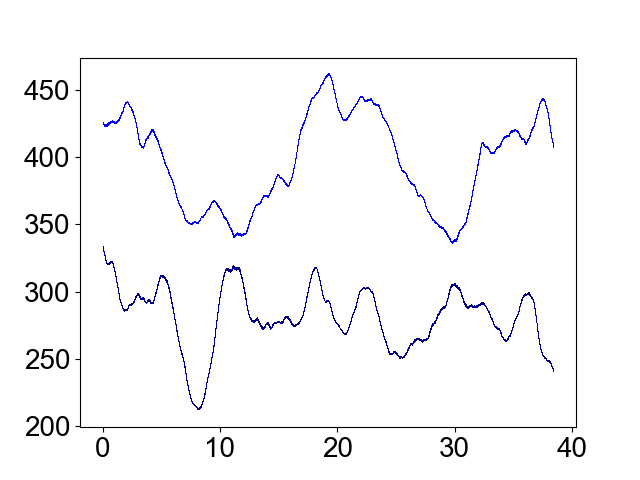

In [194]:
plt.figure(4)
plt.plot(datos.t.values, datos.x.values, ',' ,color='b')
plt.plot(datos.t.values, datos.y.values, ',', color='darkblue')

In [193]:
plt.close(4)

In [107]:
# Calculate time correlation by using arrays (faster)
# 'array' is the array over which autocorrelation is computed. 'demom' is a normalization factor. 
# 'it' is the no. of time values on which autocorrelation is computerd
# cross correlations (auto correlations if array1=array2)
def time_shift_np_av(array1, array2 ,denom, ilag):
    return np.mean(array1[:-ilag] * array2[ilag:])/denom
# displacement correlations (mean squared displacement if array1=array2)
def time_diff_shift_np_av(array1, array2, ilag):
    return np.mean( (array1[:-ilag]-array2[ilag:]) * (array1[:-ilag]-array2[ilag:]) )

In [196]:
datos = pd.read_pickle('blanca_295.pkl.xz', compression='xz')
nframes = len(datos)
print('nframes = ', nframes, '\n')
datos.head()

nframes =  37000 



,x,y,t
0,363.5145,532.7498,0.000000
1,363.4976,532.7566,0.001333
2,363.4930,532.7407,0.002667
3,363.6063,532.8949,0.004000
4,363.3738,533.0354,0.005333


In [198]:
Dodd_xy = 0.
Dodd_yx = 0.
vx = np.diff(datos.x.values)/np.diff(datos.t.values)
vy = np.diff(datos.y.values)/np.diff(datos.t.values)
for ilag in range(1,int(nframes/2)):
    Dodd_yx = Dodd_yx - time_shift_np_av(vx, vy, 750, ilag)     
    Dodd_xy = Dodd_xy + time_shift_np_av(vy, vx, 750, ilag)
    if ilag%100==0:
        printp('Dodd_xy: ' + str(Dodd_xy) + '\tDodd_yx: ' + str(Dodd_yx) )
Dodd = -(Dodd_xy + Dodd_yx)/2
print('\n')
print('Dodd = ', Dodd, '\n\n')

D_y = 0.
D_x = 0.
for ilag in range(1,int(nframes/2)):
    D_x = D_x + time_shift_np_av(vx , vx, 750, ilag) 
    D_y = D_y + time_shift_np_av(vy , vy, 750, ilag) 
    if ilag%100 ==0:
        printp('D_x: ' + str(D_x) + '\tD_y: ' + str(D_y))
D = (D_x + D_y)/2
print('\n')
print('D = ', D)

Dodd_xy: -218.88781262531663	Dodd_yx: -187.28543095201655

Dodd =  193.84385892078998 


D_x: 185.75724976853184	D_y: -53.9956543441418447

D =  60.23180285793987


In [200]:
msd = np.zeros(nframes-1)
for ilag in range(1,int(nframes-1)):
    msd[ilag] = time_diff_shift_np_av(datos.x.values, datos.x.values, ilag) + time_diff_shift_np_av(datos.y.values, datos.y.values, ilag) 
    if ilag%100==0:
        printp('msd(' + str(ilag) +'): ' + str(msd[ilag]))
        
xsd = np.zeros(nframes-1)
for ilag in range(1,int(nframes-1)):
    xsd[ilag] = time_diff_shift_np_av(datos.x.values, datos.y.values, ilag)
    if ilag%100==0:
        printp('xsd(' + str(ilag) +'): ' + str(xsd[ilag]))        

xsd(36900): 18798.136606856802

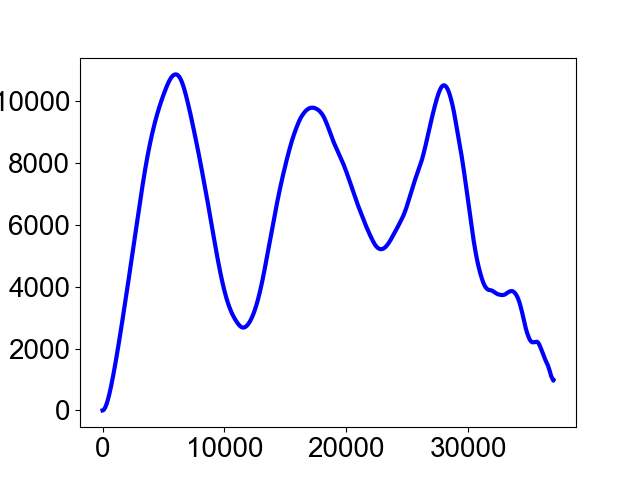

In [201]:
plt.figure(5)
plt.plot(msd, color='blue', lw=3)

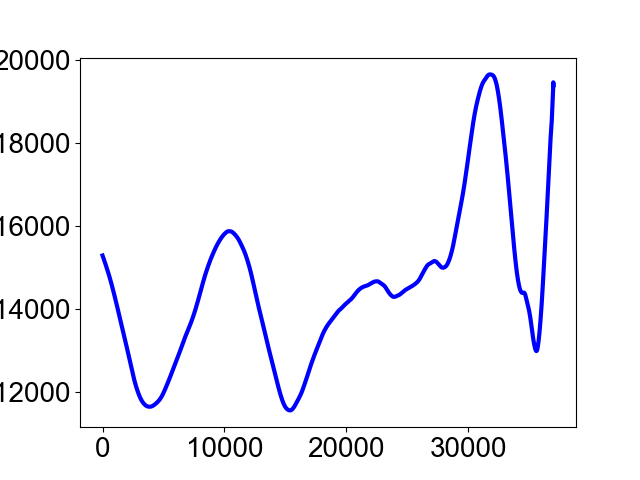

In [208]:
plt.figure(6)
plt.plot(xsd[2:], color='blue', lw=3)

In [207]:
plt.close(6)